<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=160px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Barabasi-Albert Model and Preferential Attachment</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

from collections import Counter

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from itertools import chain
import networkx as nx

import tqdm as tq
from tqdm import tqdm
tqdm.pandas()

import watermark

%load_ext watermark
%matplotlib inline

Watermark the notebook with current versions of all loaded libraries

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 27167f143cf1de29d953abeeb32fe4725588f66b

tqdm      : 4.62.0
numpy     : 1.19.2
watermark : 2.1.0
json      : 2.0.9
networkx  : 2.5
matplotlib: 3.3.2
cartopy   : 0.18.0
pandas    : 1.1.3



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Flight Data

We start by loading up the data from the "T-100 Domestic Segment (U.S. Carriers)" file covering the entire year of 2019 that we downloaded from [BTS](https://www.transtats.bts.gov/Tables.asp?DB_ID=110&DB_Name=Air%20Carrier%20Statistics%20(Form%2041%20Traffic)-%20%20U.S.%20Carriers). The online database allows you to select many fields, but we'll use just a few.

In [4]:
flights = pd.read_csv('data/336781026_T_T100D_SEGMENT_US_CARRIER_ONLY.zip',
                     usecols=['ORIGIN', 'DEST', 'PASSENGERS'], 
                     dtype={'ORIGIN':'str', 'DEST': 'str', 'PASSENGERS':'int'})

We aggregate across all the flights connecting the same _ORIGIN_ and _DEST_

In [5]:
edges = flights.groupby(['ORIGIN', 'DEST'], as_index=False).sum()

In the end we have about 27,300 edges

In [6]:
edges.shape[0]

27302

We remove self loops

In [7]:
edges = edges[edges['ORIGIN'] != edges['DEST']].copy()

Bringing the total down to just over 27,000

In [8]:
edges.shape[0]

27072

# Airport Data

As before, we load the airport information from the 'Master Coordinate' dataset downloaded from [BTS](https://www.transtats.bts.gov/Tables.asp?DB_ID=595&DB_Name=Aviation%20Support%20Tables&DB_Short_Name=Aviation%20Support%20Tables). Here we are only interested in 4 fields

In [9]:
airports = pd.read_csv('data/336781026_T_MASTER_CORD.zip', 
                       usecols=['AIRPORT', 'LATITUDE', 'LONGITUDE', 'AIRPORT_IS_LATEST'])

The _AIRPORT_IS_LATEST_ field represents the most recent coordinates for a given airport (coordinates can change when airports move to a new location in order to expand). We make sure to pick always the most recent coordinates

In [10]:
def get_latest(x):
    return x.sort_values('AIRPORT_IS_LATEST').drop(columns=['AIRPORT']).iloc[-1]

In [11]:
airports = airports.groupby('AIRPORT').progress_apply(get_latest)

100%|██████████| 6572/6572 [00:05<00:00, 1137.76it/s]


And now we can safely drop the extraneous column

In [12]:
airports.drop(columns=['AIRPORT_IS_LATEST'], inplace=True)

Here we select the airports within the US and corresponding to the flights for which we have information

In [13]:
airports.shape

(6572, 2)

And obtain a DataFrame with the Lat and Long coordinates for each of the airports at the origin and destination of each flight

In [14]:
edges = edges.merge(airports, left_on='ORIGIN', right_index=True, how='inner').merge(airports, 
            left_on='DEST', right_index=True, suffixes=('_ORIGIN', '_DEST'), how='inner')

And generate a quick visualization of full airport network

In [15]:
img_url = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73909/world.topo.bathy.200412.3x5400x2700.jpg'

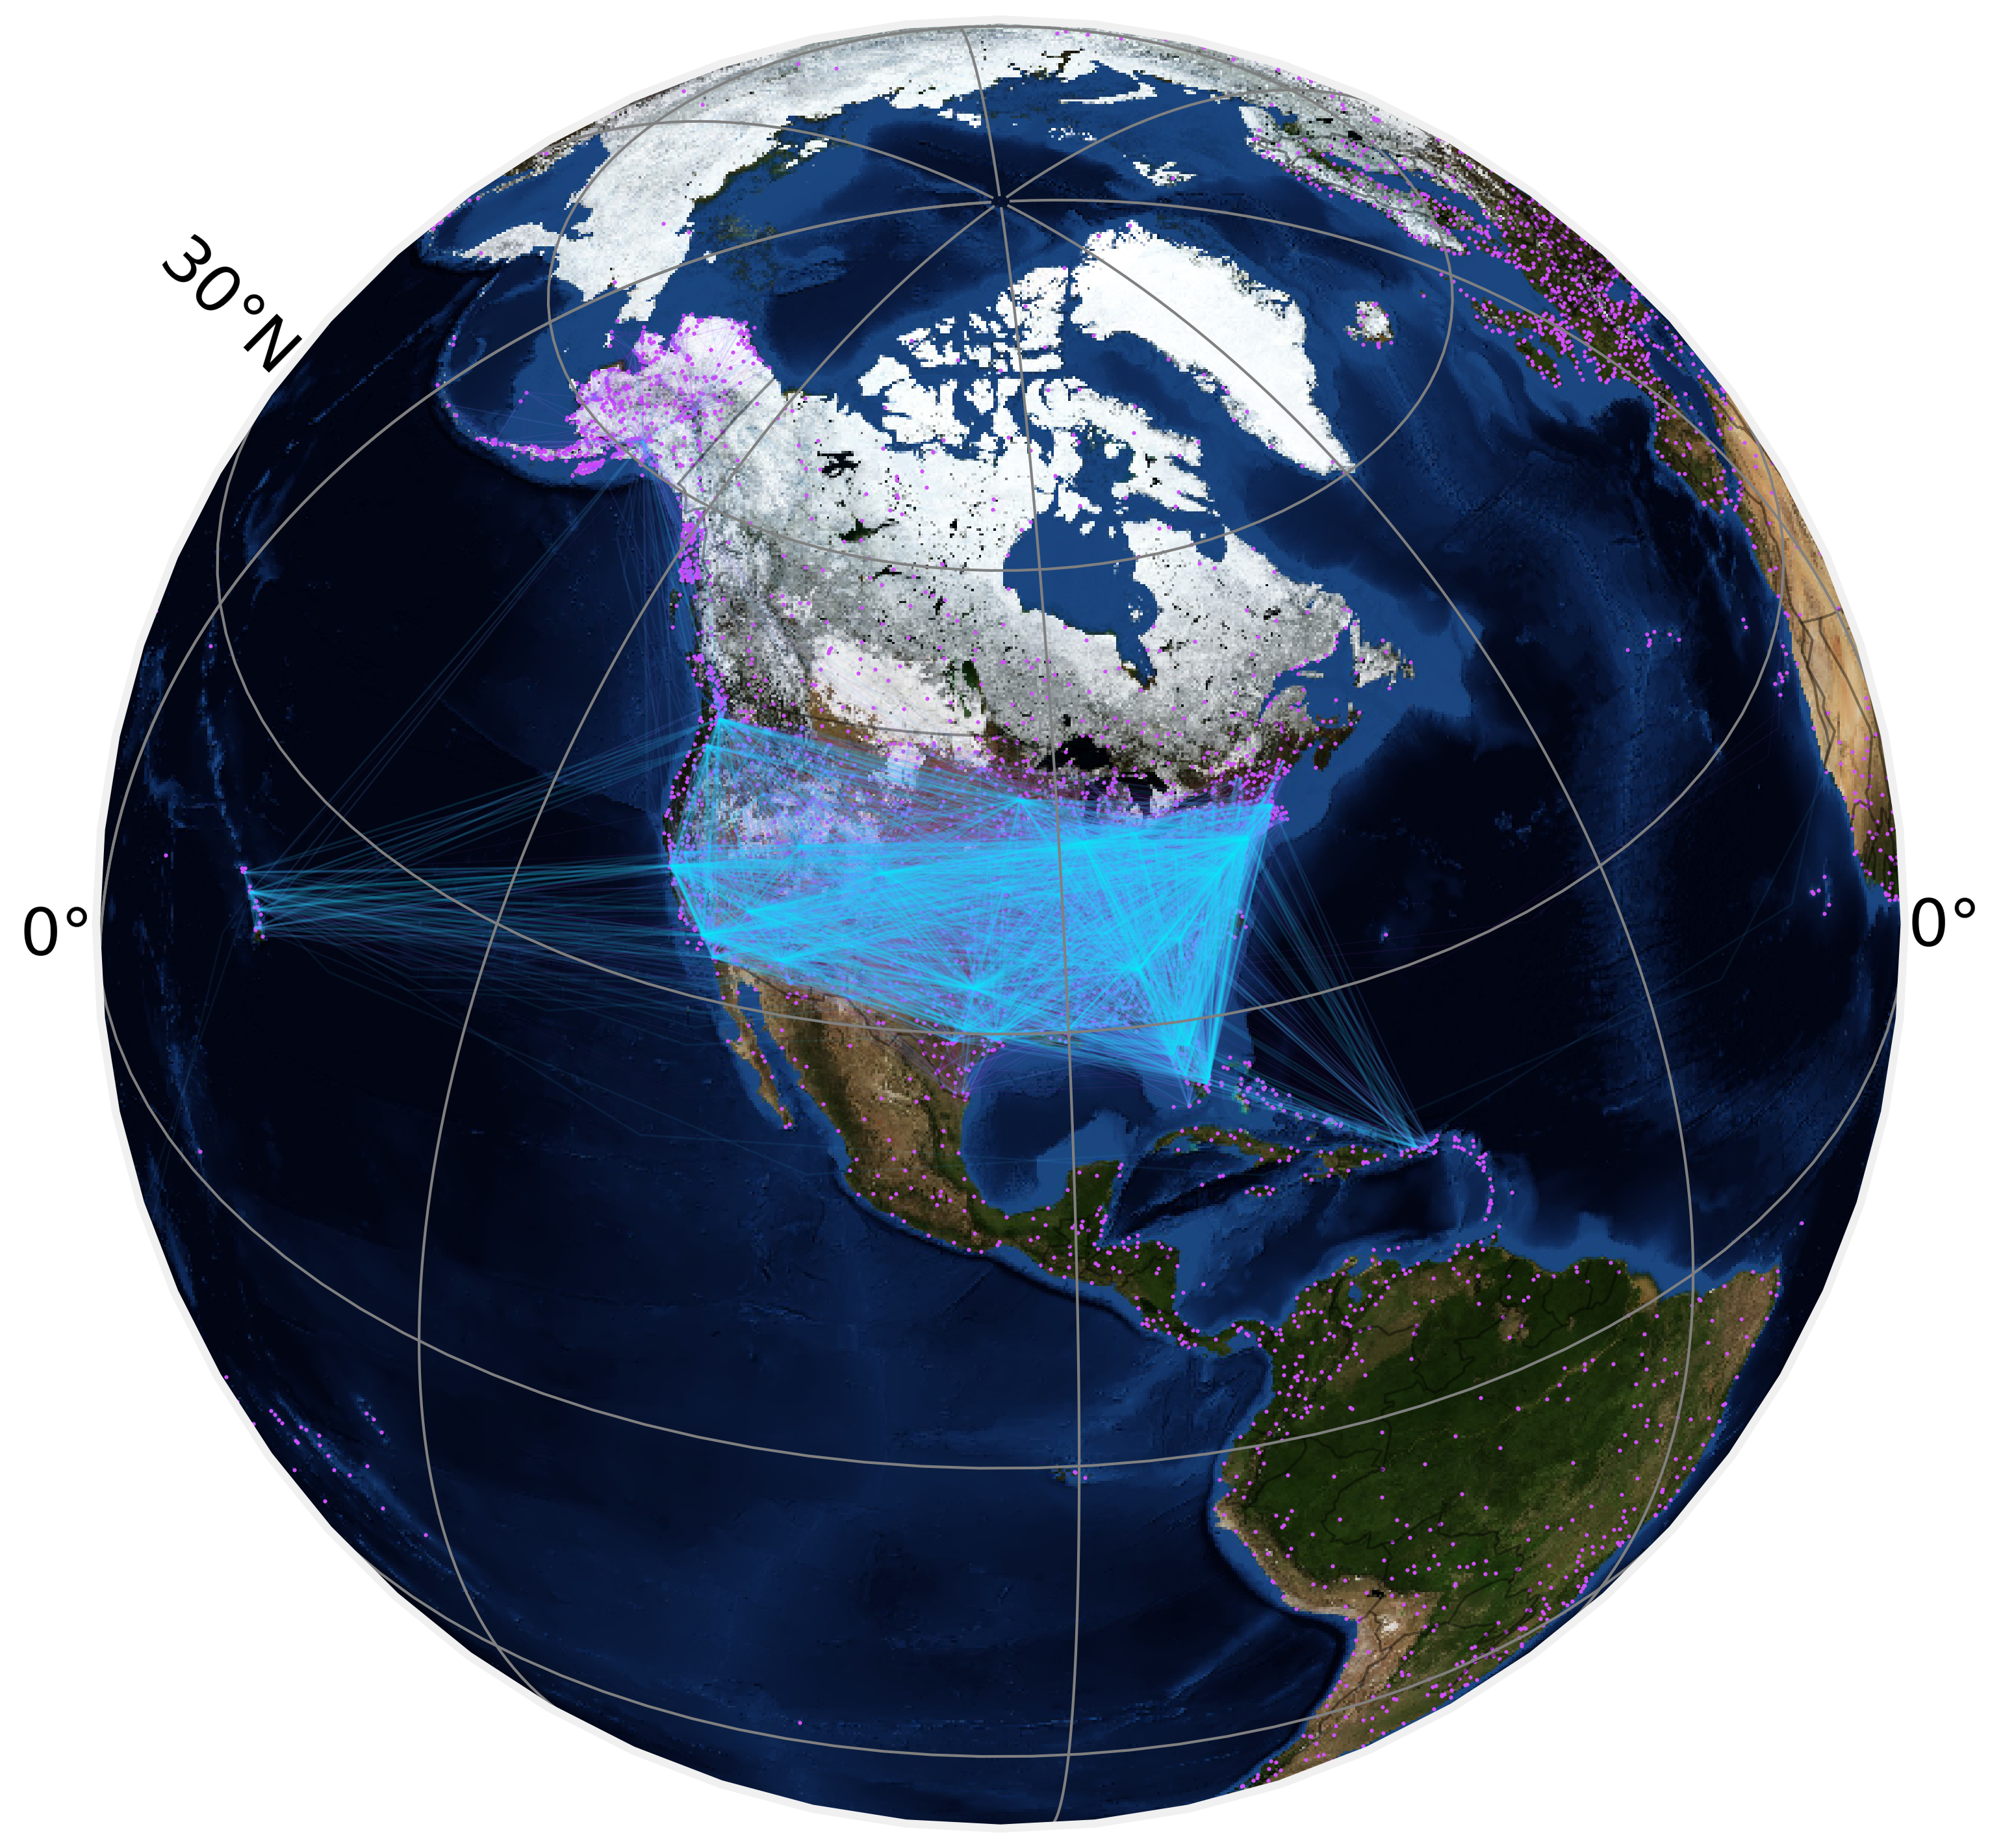

In [16]:
ax = plt.axes(projection=ccrs.Orthographic(-95, 37))
fig = plt.gcf()

# Add the blue marble figure as a "texture" on top of the globe
img = mpimg.imread(img_url, format='jpg')
ax.imshow(img, origin="upper", extent=(-180, 180, -90, 90),
          # Tell cartopy what the original projection of the data is
          transform=ccrs.PlateCarree())  

# Draw country borders
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', lw=1, alpha=0.4)

# Add longitude and latitude grid lines
ax.gridlines(draw_labels=True, dms=True, 
             xlocs=np.arange(-180, 180.1, 45), 
             ylocs=np.arange(-90, 90.1, 30),
             x_inline=False, y_inline=False, color='gray')


# Longitude corresponds to the x-axis and Latitude to the y-axis.
airports.plot(x='LONGITUDE', y='LATITUDE', kind='scatter', color=colors[1], 
              s=1, ax=ax, 
              transform=ccrs.PlateCarree())

lines = []
widths = []
cols = []

max_pax = edges.PASSENGERS.max()

for row, edge in edges.iterrows():
    width = np.log(1+edge.PASSENGERS+1)/np.log(1+max_pax)
    widths.append(width)
    cols.append(plt.cm.cool_r(width))
    lines.append(((edge.LONGITUDE_ORIGIN, edge.LATITUDE_ORIGIN), 
                  (edge.LONGITUDE_DEST, edge.LATITUDE_DEST)))

# Plot thicker edges on top to make them more visible
order = np.argsort(widths)

lines = np.asarray(lines)[order]
widths = np.asarray(widths)[order]
cols = np.asarray(cols)[order]

# Create line collection with transform information
ln_coll = matplotlib.collections.LineCollection(lines, 
                                                colors=cols, 
                                                linewidths=widths, 
                                                transform=ccrs.PlateCarree(),
                                                alpha=0.075)


ax.add_collection(ln_coll)

fig.set_size_inches(14, 10)

## Network Correlations

For simplicity, we build an undirected graph out of the edges:

In [17]:
G = nx.Graph()
G.add_edges_from(edges[['ORIGIN', 'DEST']].values)

Our network has:

In [18]:
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

Nodes: 1318
Edges: 17343


And an average degree of

In [19]:
Kmean = np.mean([deg for node, deg in G.degree()])
print(Kmean)

26.317147192716238


In [20]:
def nearest_neighbour_degree(G):
    degrees = dict(G.degree())
    KNN = {}
    counts = {}

    for node_i in G.nodes():
        degree_i = degrees[node_i]
        mean_deg = np.mean([degrees[node_j] 
                            for node_j in G.neighbors(node_i)])
        KNN[degree_i] = KNN.get(degree_i, 0) + mean_deg
        counts[degree_i] = counts.get(degree_i, 0) + 1

    maxK = max(degrees.values())+1
    knn = np.zeros(maxK)*np.nan
        
    for degree in counts:
        KNN[degree]/=counts[degree]
        
    KNN = pd.DataFrame.from_dict(KNN, orient='index').sort_index()
    KNN.index.name='k'
    KNN.columns=['KNN']
    
    return KNN

In [21]:
knn_original = nearest_neighbour_degree(G)

Text(1.1, 30, '$\\langle k\\rangle$')

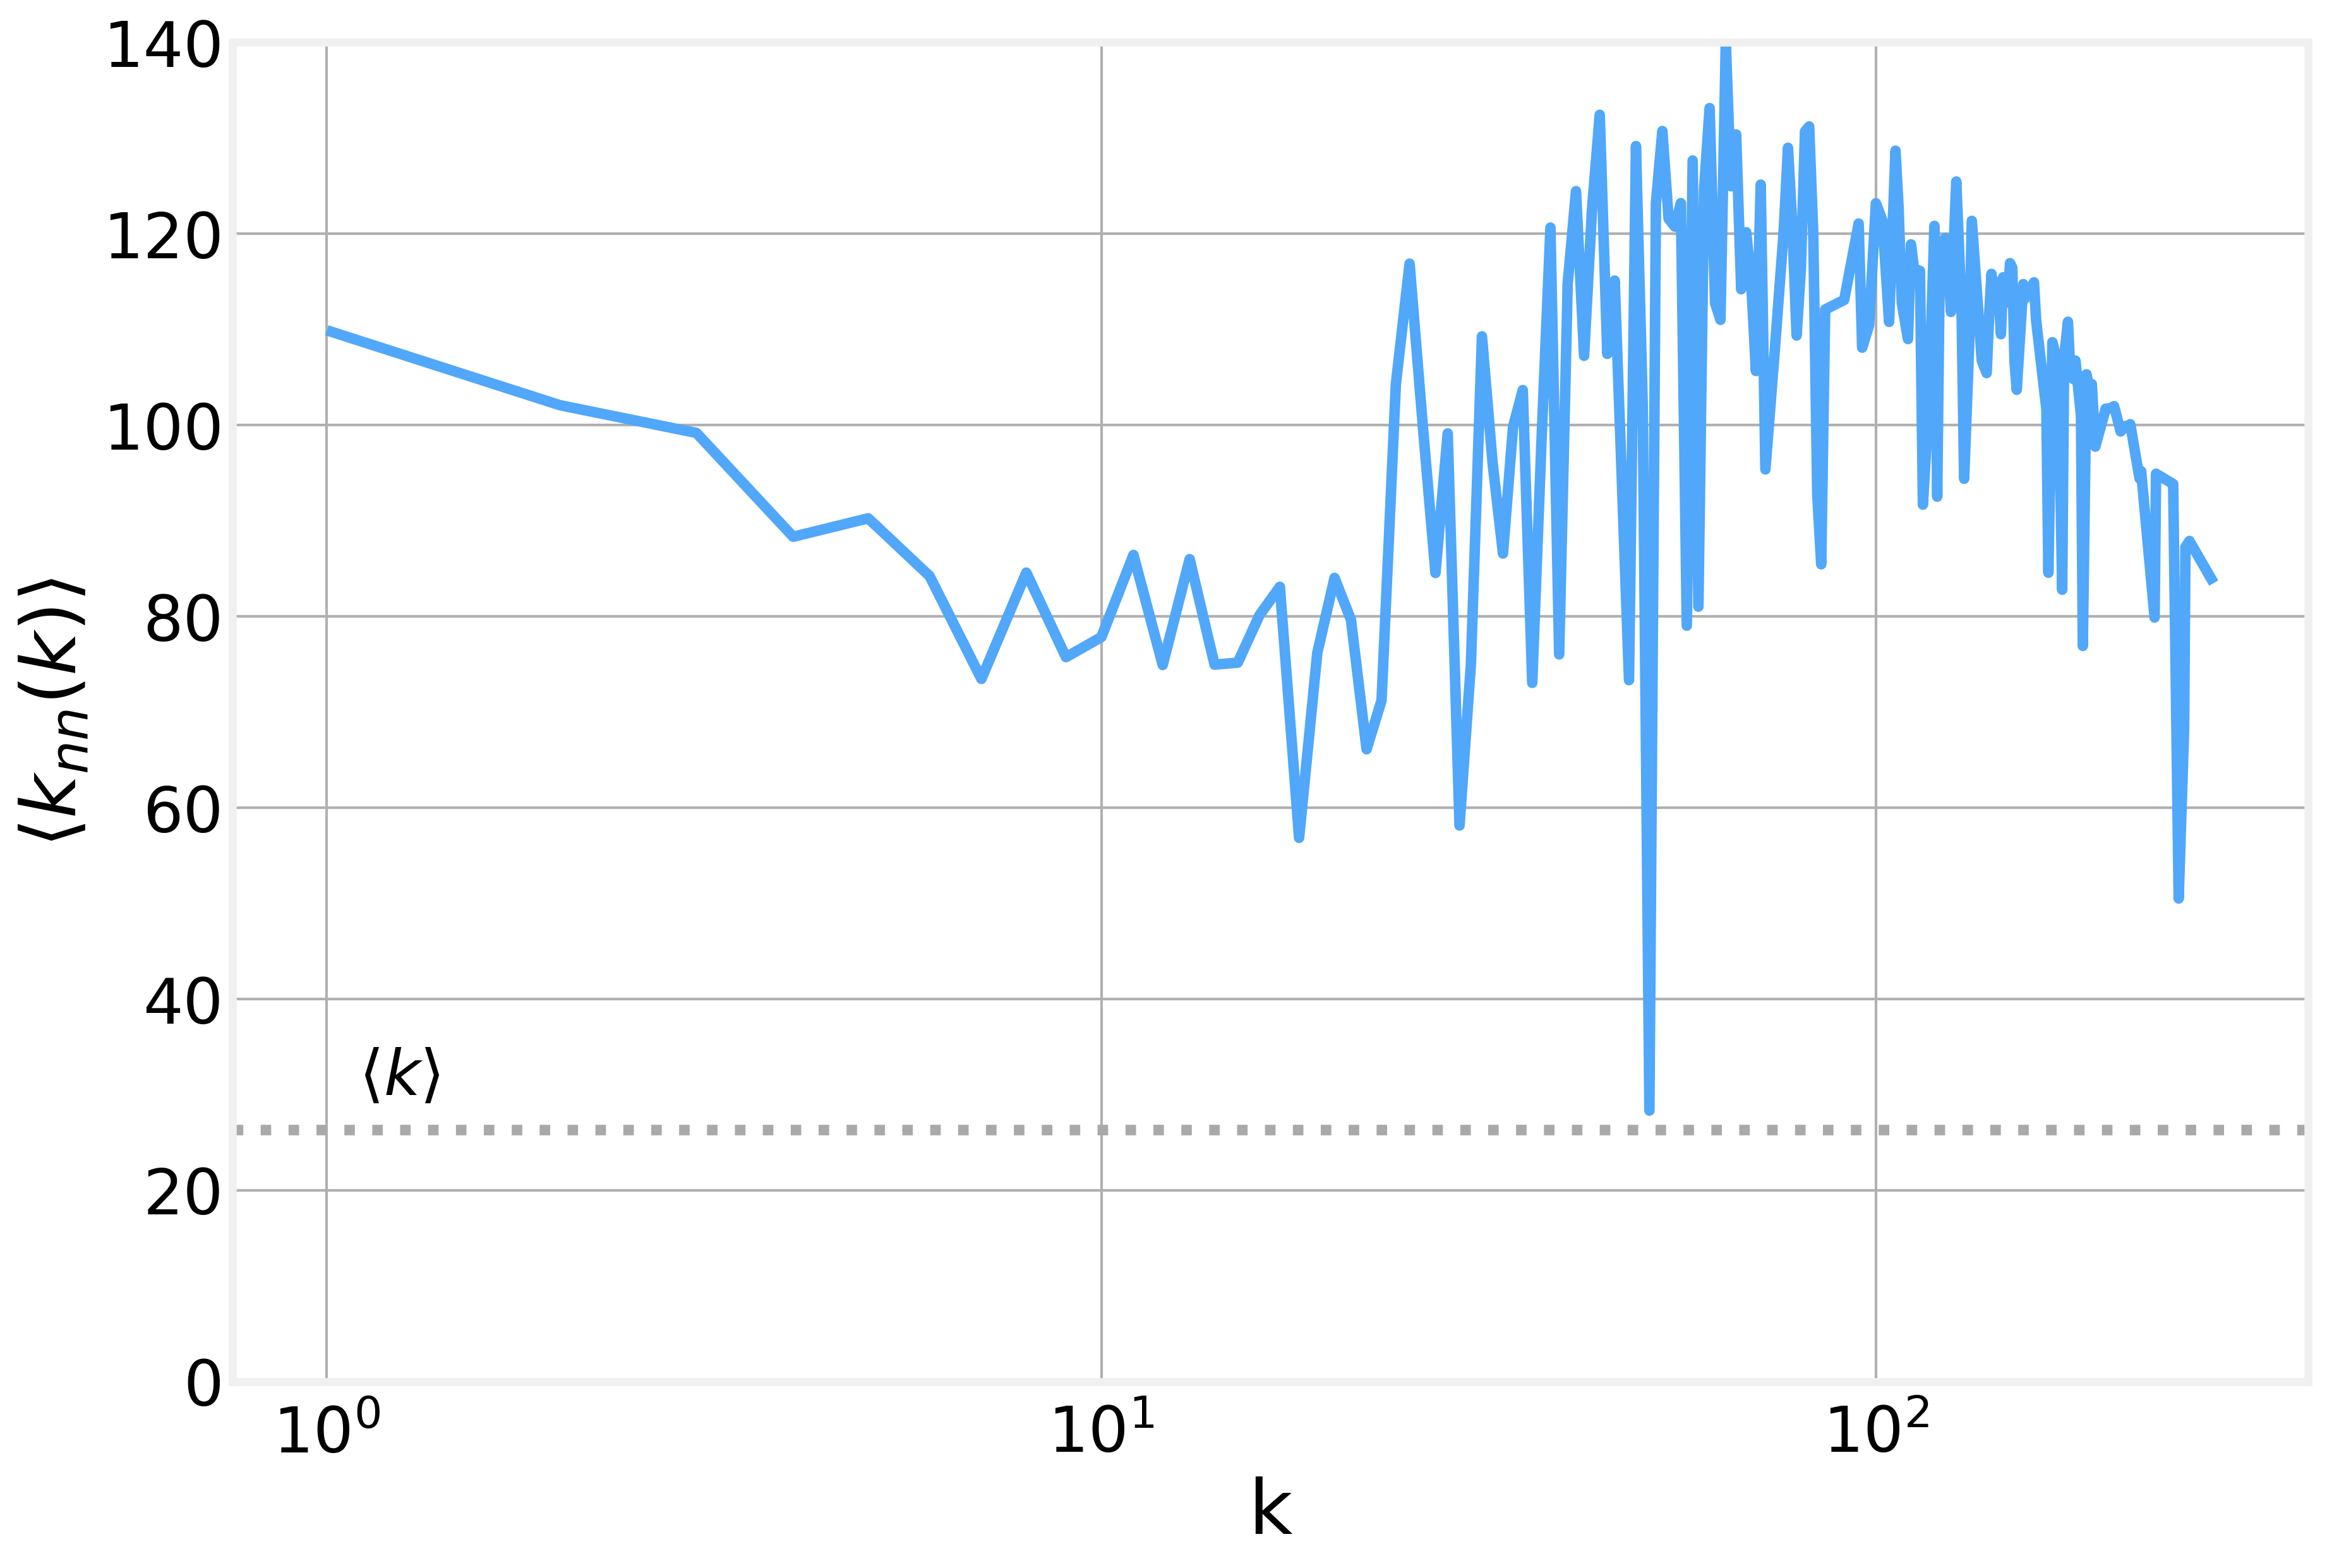

In [22]:
ax = knn_original.plot(legend=None)
ax.set_xscale('log')
ax.set_xlabel('k')
ax.set_ylabel(r'$\langle k_{nn}\left(k\right)\rangle$')

ax.axhline(y=Kmean, linestyle=':', color='darkgray')

for tick_label in ax.xaxis.get_majorticklabels():
    tick_label.set_y(-.01)
    
ax.set_ylim(0, 140)
ax.text(1.1, 30, r'$\langle k\rangle$')

# Configurational Model

Get the 'stubs' from the list of edges

In [23]:
nodes = np.array(G.edges()).flatten()

The configurational model simply reshuffles the nodes 'stubs' while preserving the number of stubs per node, i.e. its degree. In the undirected case, this can be easily achieved using just a call to __np.random.reshuffle__

In [24]:
def configurational_model(nodes):
    stubs = np.copy(nodes)
    
    # Reshuffle the stubs
    np.random.shuffle(stubs)
    
    # Reshape back into an edge list
    edges = stubs.reshape(-1,2)
    
    # Conver the list of edges into a graph
    # We use MultiGraph to preserve repeated edges
    G2 = nx.MultiGraph()
    G2.add_edges_from(edges)
    
    return G2

In [25]:
G2 = configurational_model(nodes)

Let's checkout the set of edges we generated

In [26]:
edges = pd.DataFrame(list(G2.edges()), columns=['node_i', 'node_j'])

Our simple approach has produced a relatively large number of repeated edges as well as self-loops

In [27]:
print("Original Edges:", edges.shape[0])
print("Reshuffled Edges:", edges.drop_duplicates().shape[0])
print("Self Edges:", edges[edges.node_i == edges.node_j].shape[0])

Original Edges: 17343
Reshuffled Edges: 15388
Self Edges: 62


In [28]:
knn_reshuffled = nearest_neighbour_degree(G2)

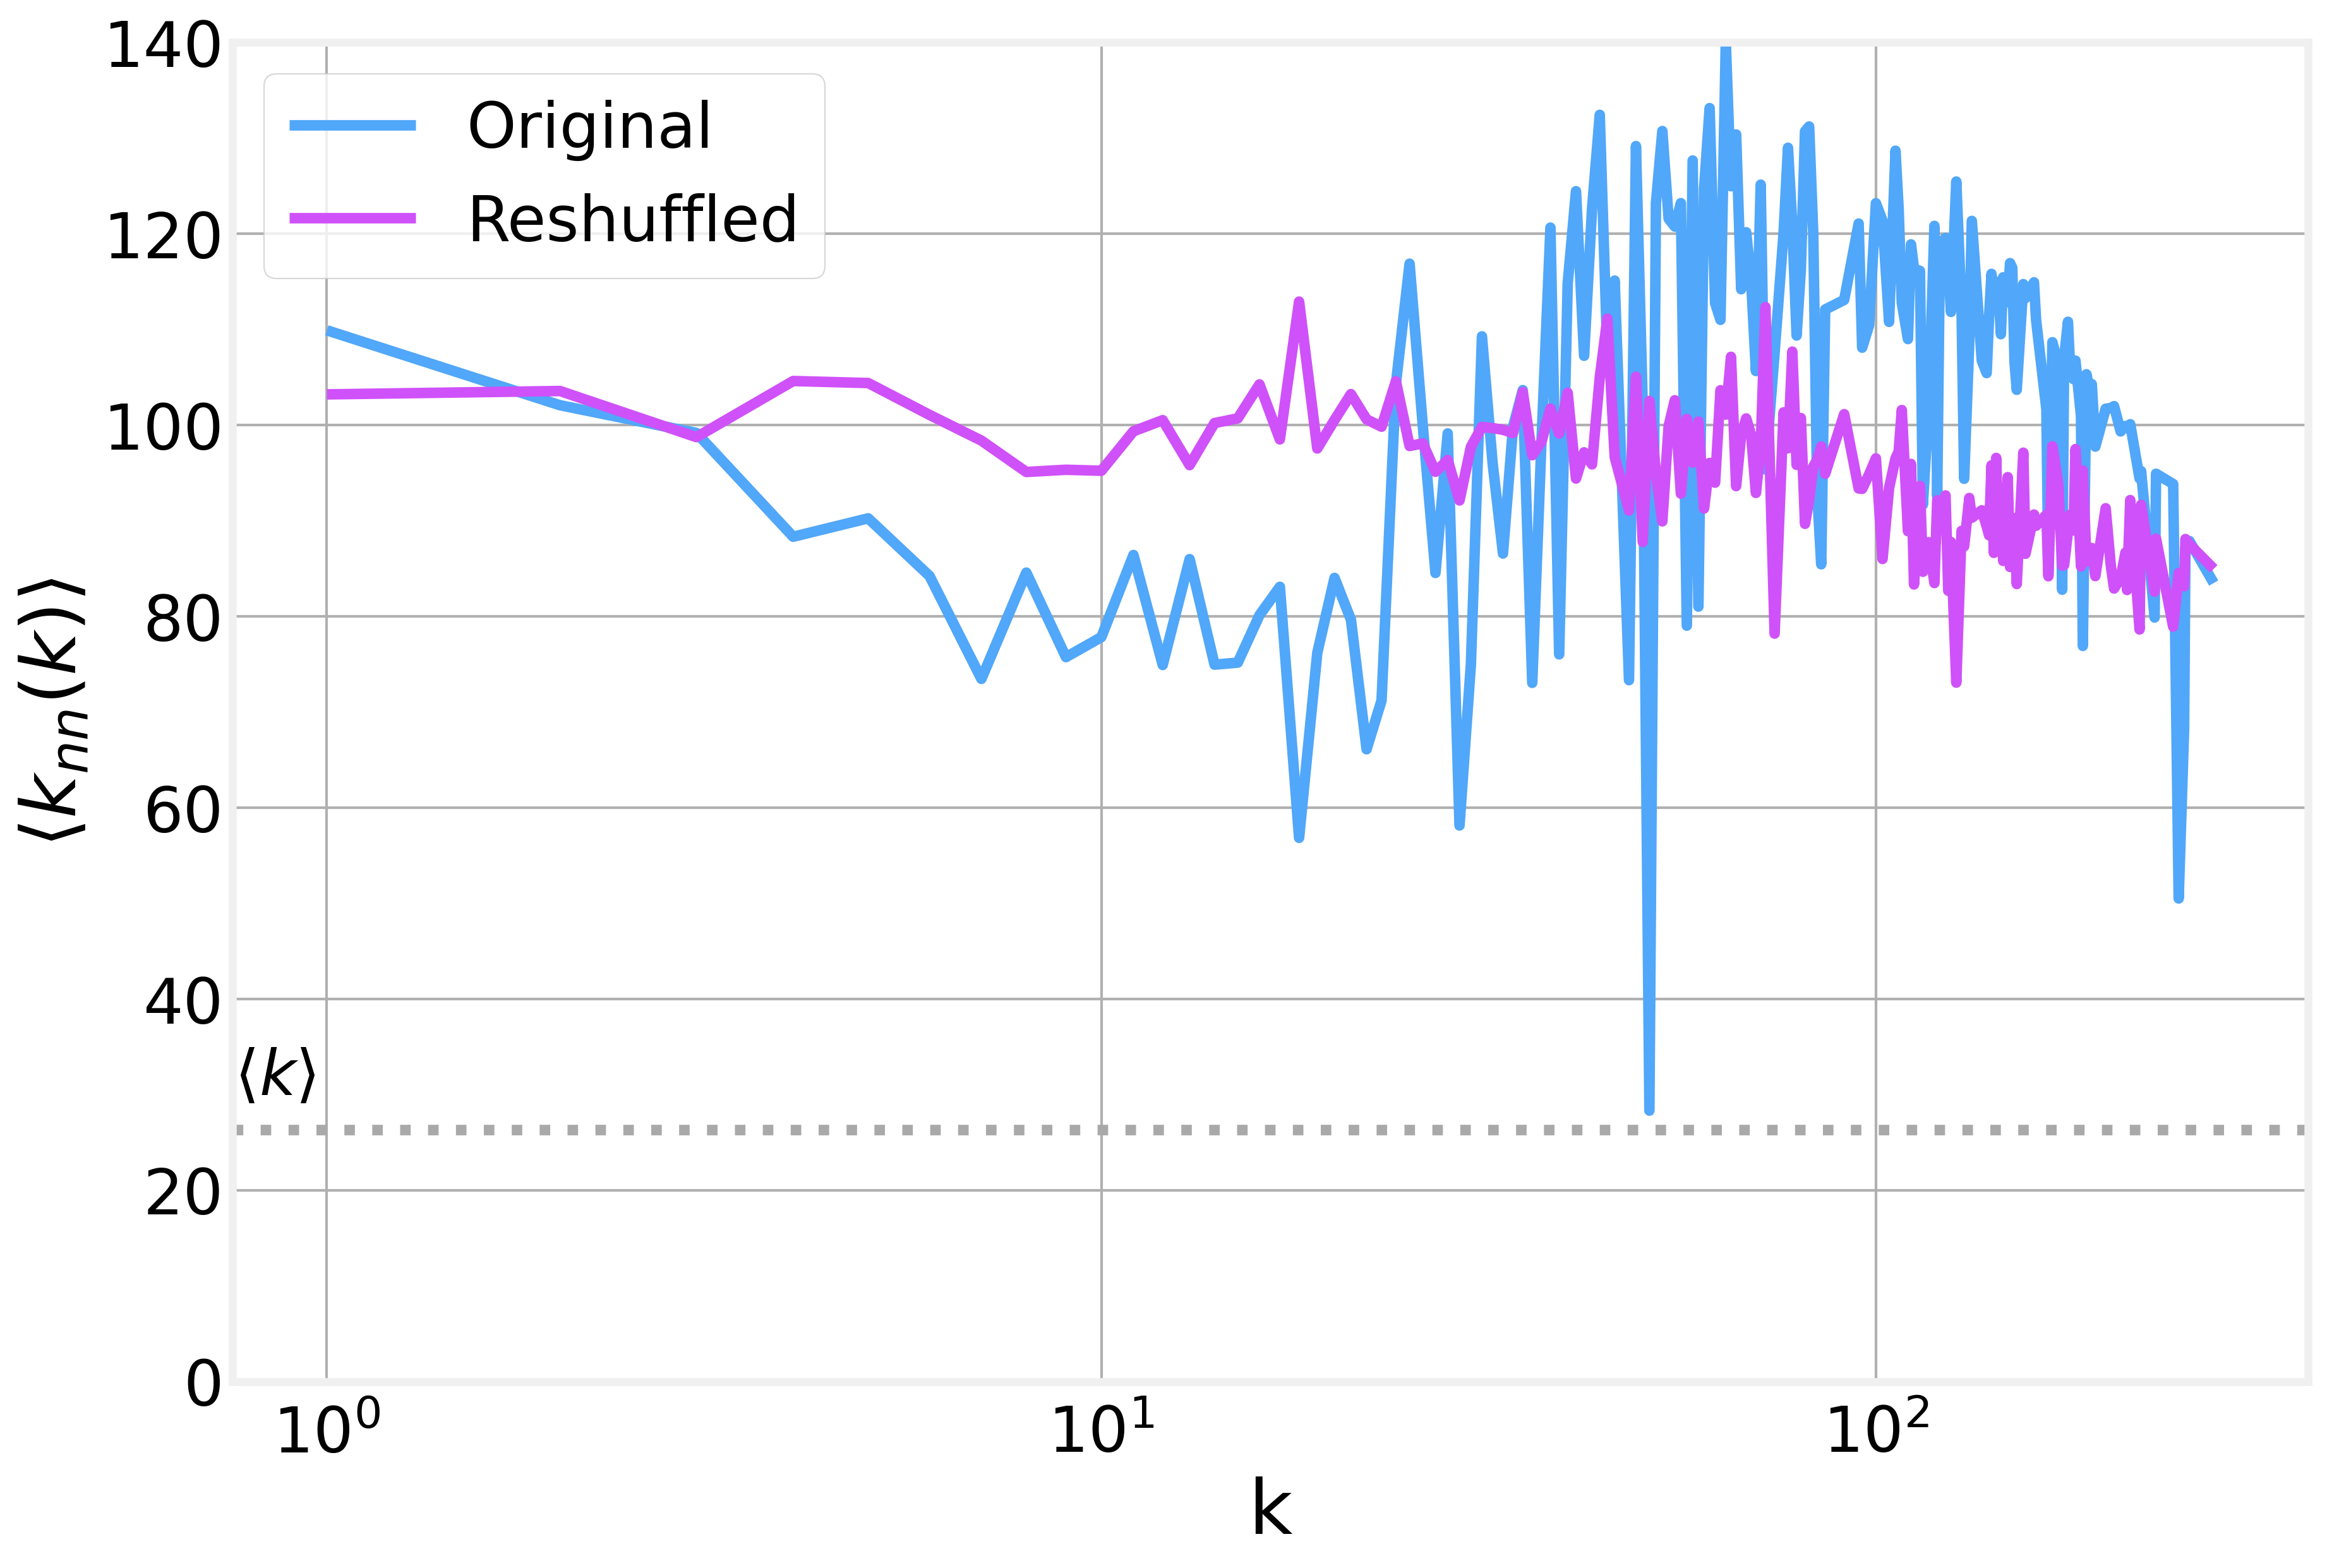

In [29]:
ax = knn_original.plot()
knn_reshuffled.plot(ax=ax)
ax.set_xscale('log')
ax.set_xlabel('k')
ax.set_ylabel(r'$\langle k_{nn}\left(k\right)\rangle$')

ax.axhline(y=Kmean, linestyle=':', color='darkgray')

for tick_label in ax.xaxis.get_majorticklabels():
    tick_label.set_y(-.01)
    
ax.set_ylim(0, 140)
ax.text(0.76, 30, r'$\langle k\rangle$')
ax.legend(['Original', 'Reshuffled'])

In [30]:
ensemble = None

for i in tqdm(range(1000), total=1000):
    G2 = configurational_model(nodes)
    knn = nearest_neighbour_degree(G2)
    
    if ensemble is None:
        ensemble = knn.copy()
    else:
        ensemble = pd.concat([ensemble, knn], axis=1)
    
ensemble.columns = range(1000)

100%|██████████| 1000/1000 [02:19<00:00,  7.19it/s]


In [31]:
Kmean2 = np.mean([deg**2 for node, deg in G.degree()])
print(Kmean2)

2643.4203338391503


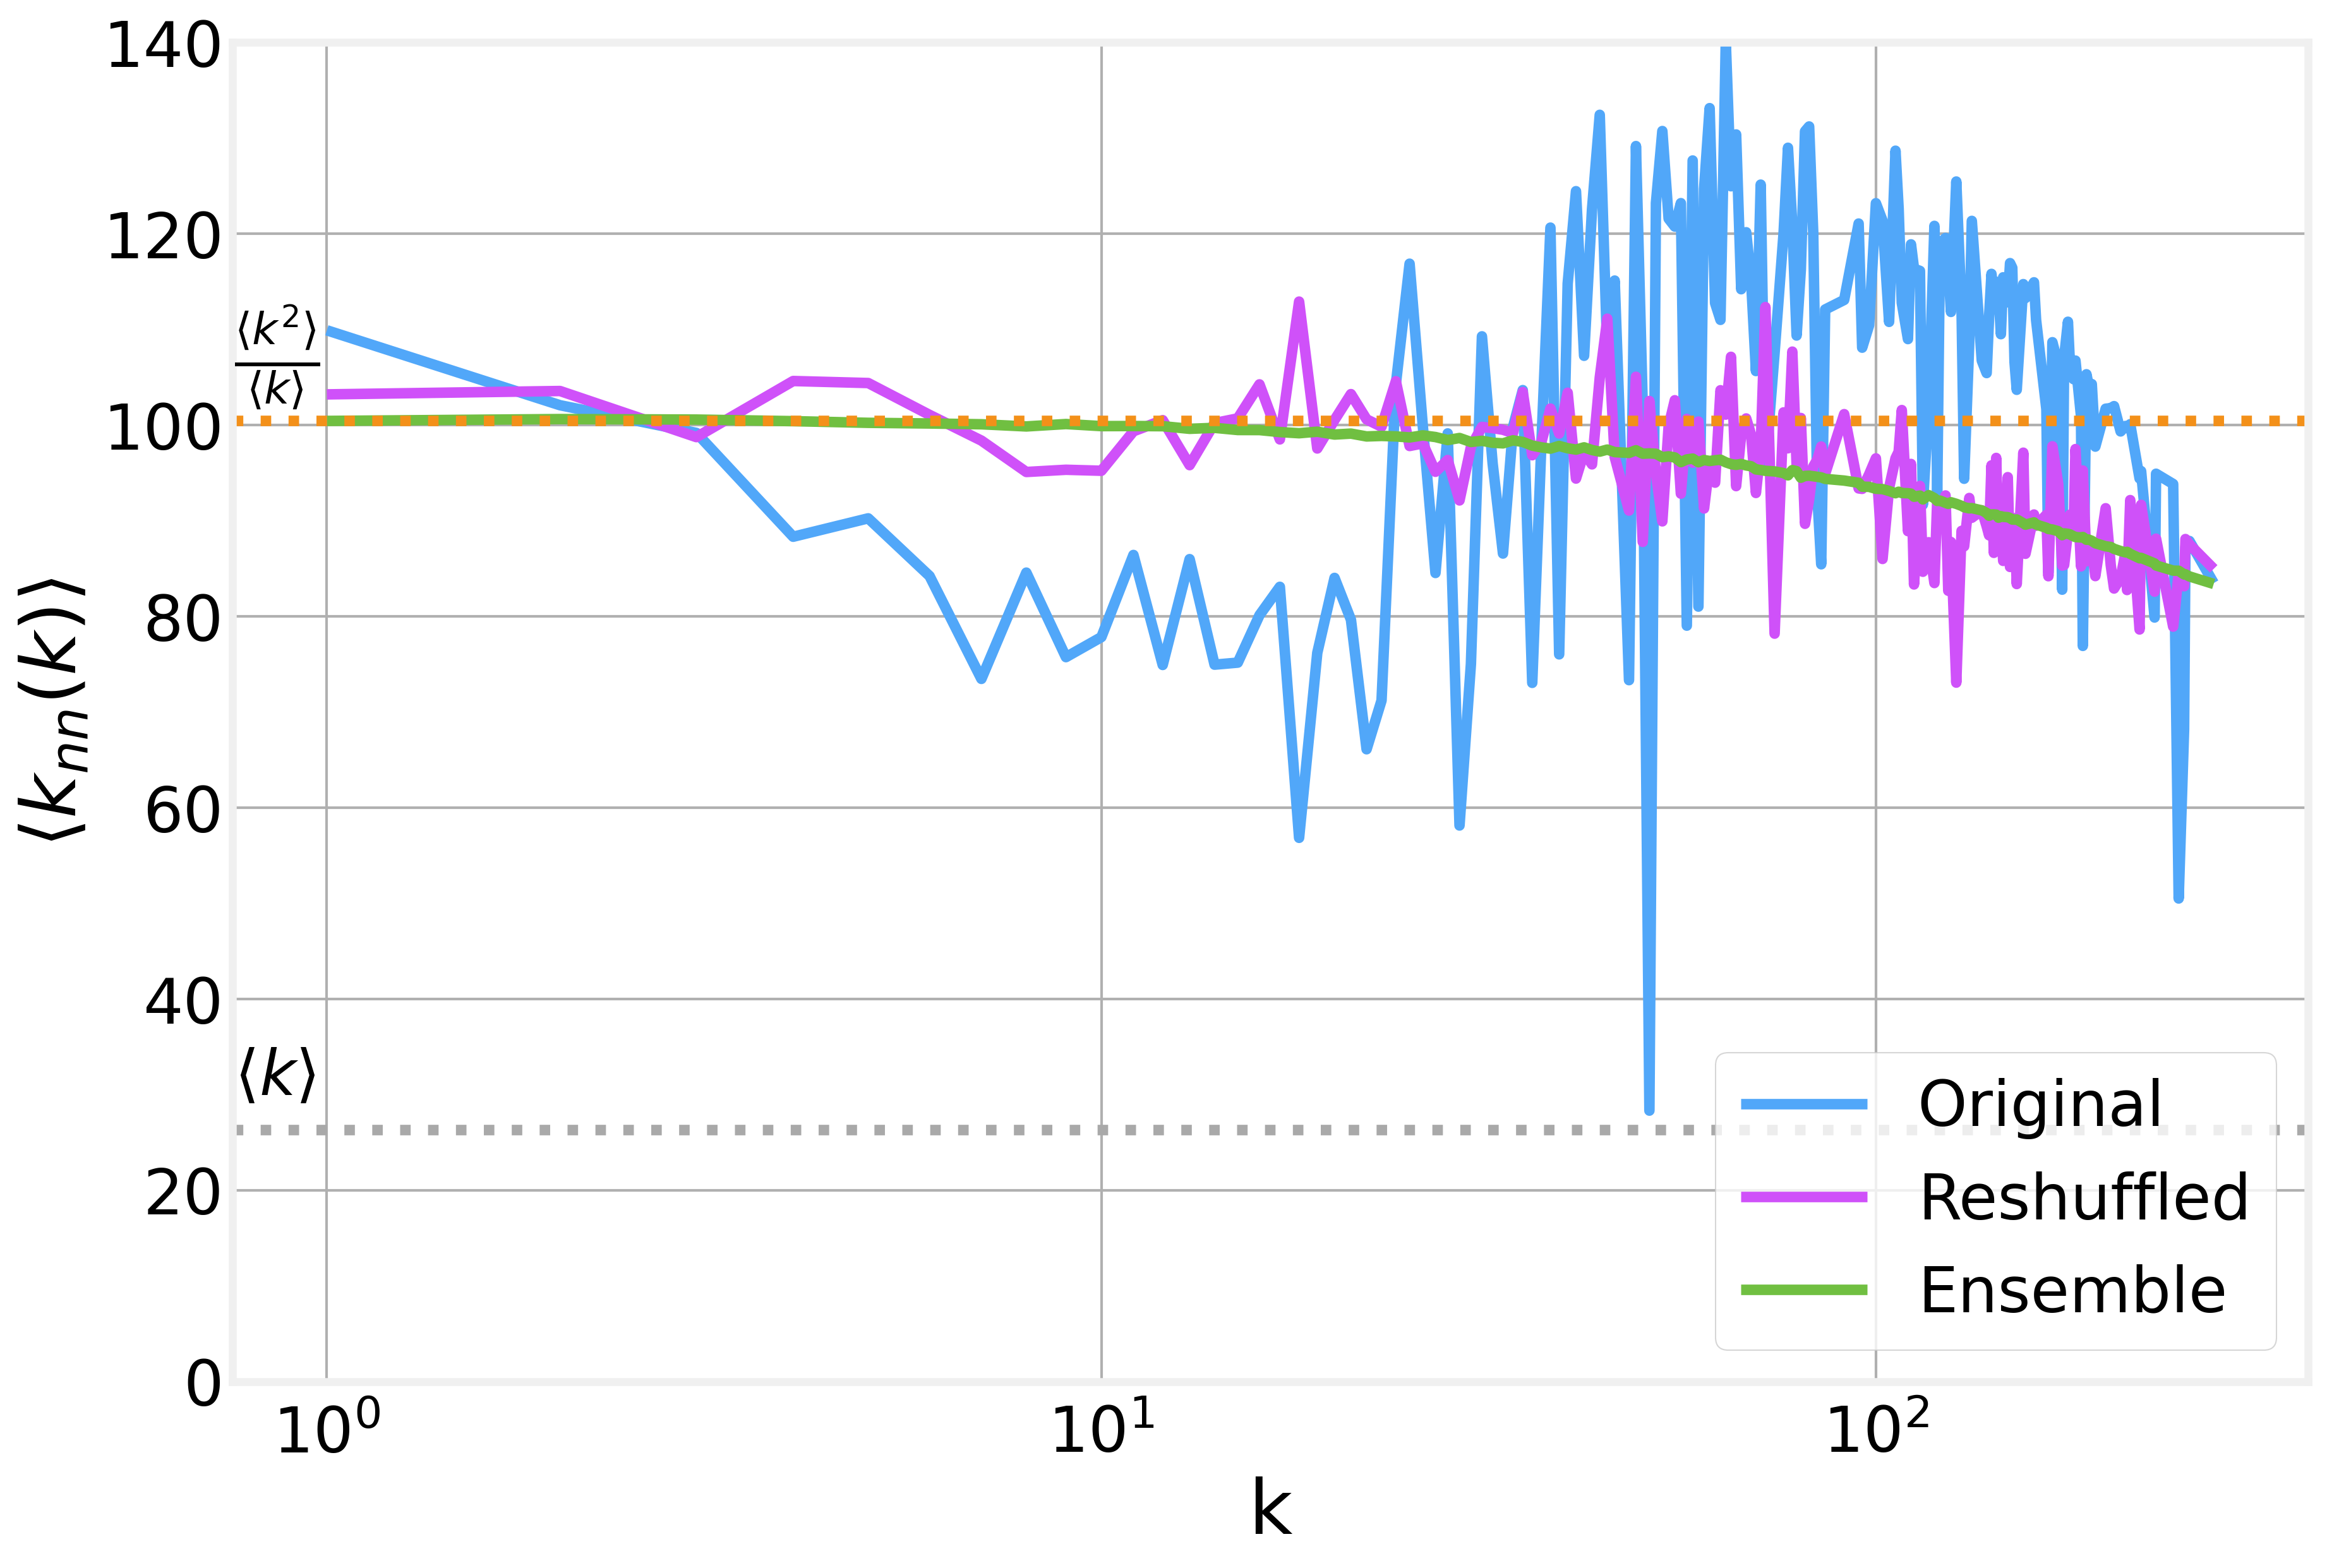

In [32]:
ax = knn_original.plot()
knn_reshuffled.plot(ax=ax)
ensemble.mean(axis=1).plot(ax=ax)
ax.set_xscale('log')
ax.set_xlabel('k')
ax.set_ylabel(r'$\langle k_{nn}\left(k\right)\rangle$')

ax.axhline(y=Kmean, linestyle=':', color='darkgray')
ax.axhline(y=Kmean2/Kmean, linestyle=':', color=colors[3])


for tick_label in ax.xaxis.get_majorticklabels():
    tick_label.set_y(-.01)
    
ax.set_ylim(0, 140)
ax.text(0.76, 30, r'$\langle k\rangle$')
ax.text(0.76, 105, r'$\frac{\langle k^2\rangle}{\langle k\rangle}$')

ax.legend(['Original', 'Reshuffled', 'Ensemble'], loc='lower right')

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>